In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
gc = GeonamesCache()
d = gc.get_countries_by_names()
country_code = pd.DataFrame([(n, d[n]['iso3']) for n in d.keys()])
country_code[0] = country_code[0].apply(lambda x: x.lower())
country_code.head()

,0,1
0,saudi arabia,SAU
1,aruba,ABW
2,vanuatu,VUT
3,jordan,JOR
4,ethiopia,ETH


In [3]:
cpair = np.load('cpair.npy')
g = gt.Graph(directed=False)
g.vertex_properties['id'] = g.add_edge_list(cpair, hashed=True)
cname = np.load('cname.npy')
names = np.array(pd.merge(pd.DataFrame(g.vertex_properties['id'].a),
                          pd.DataFrame(cname), left_on=0, right_on=0)[1])
g.vertex_properties['name'] = g.new_vertex_property("string", names)
g

<Graph object, undirected, with 195 vertices and 782240 edges at 0x7f80f89322e8>

In [4]:
country = np.array(pd.merge(pd.DataFrame(names), country_code, how='left', on=0))

In [5]:
for c in country:
    if c[1] is np.nan:
        print(c[0])

usa
england
scotland
south-korea
czech-republic
south-africa
hong-kong
peoples-r-china
wales
new-zealand
u-arab-emirates
north-ireland
yugoslavia
zaire
byelarus
cape-verde
cote-ivoire
cent-afr-republ
costa-rica
french-guiana
congo
sri-lanka
rep-of-georgia
saudi-arabia
dominican-rep
trinid-&-tobago
burkina-faso
malagasy-republ
fr-polynesia
solomon-islands
cook-islands
mongol-peo-rep
bosnia-&-herceg
sierra-leone
el-salvador
papua-n-guinea
st-lucia
new-caledonia
neth-antilles
w-ind-assoc-st
serbia-monteneg
boston-univ,
sao-tome-&-prin


In [6]:
country[country[:, 0] == 'england', 1] = 'GBR'
country[country[:, 0] == 'peoples-r-china', 1] = 'CHN'
country[country[:, 0] == 'usa', 1] = 'USA'
country[country[:, 0] == 'new-zealand', 1] = 'NZL'
country[country[:, 0] == 'south-africa', 1] = 'ZAF'
country[country[:, 0] == 'byelarus', 1] = 'BLR'
country[country[:, 0] == 'congo', 1] = 'COD'
country[country[:, 0] == 'mongol-peo-rep', 1] = 'MNG'
country[country[:, 0] == 'czech-republic', 1] = 'CZE'
country[country[:, 0] == 'south-korea', 1] = 'KOR'
country[country[:, 0] == 'saudi-arabia', 1] = 'SAU'
country[country[:, 0] == 'u-arab-emirates', 1] = 'ARE'
country[country[:, 0] == 'hong-kong', 1] = 'HKG'
country[country[:, 0] == 'rep-of-georgia', 1] = 'GEO'
country[country[:, 0] == 'bosnia-&-herceg', 1] = 'BIH'
country[country[:, 0] == 'papua-n-guinea', 1] = 'PNG'

In [7]:
%time cluster = gt.minimize_blockmodel_dl(g)

CPU times: user 28.6 s, sys: 3.54 s, total: 32.1 s
Wall time: 28.2 s


In [8]:
country = np.hstack((country, cluster.b.a[:, None]))
country = pd.DataFrame(country).rename_axis({0:'name', 1:'code', 2:'group'}, axis=1).dropna()
country.set_index('code', inplace=True)

In [9]:
cmap = plt.get_cmap('gnuplot')
colormap = [cmap(j) for j in np.linspace(0, 1, max(country.group.unique()) + 1)]

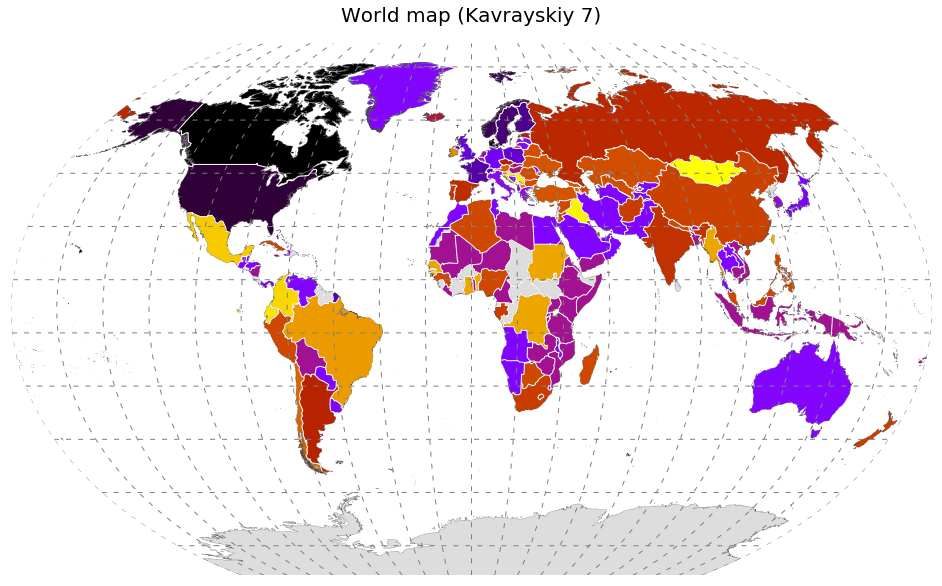

In [10]:
#fig = plt.figure(figsize=(22, 12))
#ax = fig.add_subplot(111, facecolor='w', frame_on=False)
m = Basemap(projection='kav7', lon_0=0, resolution='c')

n_graticules = 18
parallels = np.arange(-80., 90, n_graticules)
meridians = np.arange(0., 360., n_graticules)
lw = 1
dashes = [5,7] # 5 dots, 7 spaces... repeat
graticules_color = 'grey'

fig1 = plt.figure(figsize=(16,20))
fig1.patch.set_facecolor('white')
ax = fig1.add_axes([0.1,0.1,0.8,0.8])

m.drawmapboundary(color='white', 
                  linewidth=0.0, 
                  fill_color='white')
m.drawparallels(parallels, 
                linewidth=lw, 
                dashes=dashes, 
                color=graticules_color)
m.drawmeridians(meridians, 
                linewidth=lw, 
                dashes=dashes, 
                color=graticules_color)
m.drawcoastlines(linewidth=0)
#m.fillcontinents('black', 
#                 lake_color='white')
m.drawcountries(linewidth=1, 
                linestyle='solid', 
                color='white', 
                zorder=30)

title = plt.title('World map (Kavrayskiy 7)', 
                  fontsize=20) 
title.set_y(1.03) # Move the title a bit for niceness



#m.drawmapboundary(color='w')
shapefile = 'countries/ne_10m_admin_0_countries_lakes'
m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

for info, shape in zip(m.units_info, m.units):
    iso = info['ADM0_A3']
    color = colormap[country.ix[iso].group] if iso in country.index else '#dddddd'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)

# Cover up Antarctica so legend can be placed over it.
#ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

# Draw color legend.
#ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
#cmap = mpl.colors.ListedColormap(scheme)
#cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
#cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# Set the map footer.
#plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')

plt.savefig('worldmap.png', bbox_inches='tight', pad_inches=.2)